In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

import random, os, pathlib, time
from tqdm import tqdm
from sklearn import datasets

In [2]:
device = torch.device("cuda:1")
# device = torch.device("cpu")

## MNIST dataset

In [3]:
import mylibrary.datasets as datasets
import mylibrary.nnlib as tnn

In [4]:
mnist = datasets.FashionMNIST()
# mnist.download_mnist()
# mnist.save_mnist()
train_data, train_label_, test_data, test_label_ = mnist.load()

train_data = train_data / 255.
test_data = test_data / 255.

# train_label = tnn.Logits.index_to_logit(train_label_)
train_size = len(train_label_)

In [5]:
## converting data to pytorch format
train_data = torch.Tensor(train_data)
test_data = torch.Tensor(test_data)
train_label = torch.LongTensor(train_label_)
test_label = torch.LongTensor(test_label_)

In [6]:
input_size = 784
output_size = 10

In [7]:
class MNIST_Dataset(data.Dataset):
    
    def __init__(self, data, label):
        self.data = data
        self.label = label
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img, lbl = self.data[idx], self.label[idx]
        return img, lbl

In [8]:
train_dataset = MNIST_Dataset(train_data, train_label)
test_dataset = MNIST_Dataset(test_data, test_label)

In [9]:
batch_size = 50
train_loader = data.DataLoader(dataset=train_dataset,
                                    num_workers=4, 
                                    batch_size=batch_size, 
                                    shuffle=True)

test_loader = data.DataLoader(dataset=test_dataset,
                                    num_workers=4, 
                                    batch_size=batch_size, 
                                    shuffle=False)

In [223]:
class DistanceTransform(nn.Module):
    
    def __init__(self, input_dim, num_centers):
        super().__init__()
        self.input_dim = input_dim
        self.num_centers = num_centers
        
        self.centers = torch.randn(num_centers, input_dim)/3.
        self.centers = nn.Parameter(self.centers)
        
    def forward(self, x):
        x = x[:, :self.input_dim]
        dists = torch.cdist(x, self.centers)
        
        ### normalize similar to UMAP
#         dists = dists-dists.min(dim=1, keepdim=True)[0]
#         dists = dists-dists.mean(dim=1, keepdim=True)
        
#         dists = dists/dists.std(dim=1, keepdim=True)
#         dists = torch.exp(-dists)
        
        return dists

In [224]:
dt = DistanceTransform(784, 784)

In [225]:
dists = dt(torch.randn(2, 784))

In [226]:
dists.shape

torch.Size([2, 784])

In [229]:
model = nn.Sequential(
                DistanceTransform(784, 785),
                nn.LayerNorm(785),
                nn.BatchNorm1d(785),
                nn.Linear(785, 200),
                nn.LeakyReLU(),
                nn.Linear(200, 50),
                nn.LeakyReLU(),
                nn.Linear(50, 10))
model.to(device)

Sequential(
  (0): DistanceTransform()
  (1): LayerNorm((785,), eps=1e-05, elementwise_affine=True)
  (2): BatchNorm1d(785, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=785, out_features=200, bias=True)
  (4): LeakyReLU(negative_slope=0.01)
  (5): Linear(in_features=200, out_features=50, bias=True)
  (6): LeakyReLU(negative_slope=0.01)
  (7): Linear(in_features=50, out_features=10, bias=True)
)

In [230]:
optimizer = optim.Adam(list(model.parameters()), 
                            lr=0.0003, weight_decay=1e-15)
criterion = nn.CrossEntropyLoss()

In [231]:
index = 0
train_accs, test_accs = [], []
model.train()
for epoch in tqdm(list(range(40))):
    train_acc = 0
    train_count = 0
    for xx, yy in train_loader:
        xx, yy = xx.to(device), yy.to(device)
        yout = model(xx)
        loss = criterion(yout, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
        correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
        train_acc += correct
        train_count += len(outputs)

    train_accs.append(float(train_acc)/train_count*100)
    train_acc = 0
    train_count = 0

    print(f'Epoch: {epoch}:{index},  Loss:{float(loss)}')
    test_count = 0
    test_acc = 0
    for xx, yy in test_loader:
        xx, yy = xx.to(device), yy.to(device)
        with torch.no_grad():
            yout = model(xx)
        outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
        correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
        test_acc += correct
        test_count += len(xx)
    test_accs.append(float(test_acc)/test_count*100)
    print(f'Train Acc:{train_accs[-1]:.2f}%, Test Acc:{test_accs[-1]:.2f}%')
    print()

### after each class index is finished training
print(f'\t-> MAX Train Acc {max(train_accs)} ; Test Acc {max(test_accs)}')

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0:0,  Loss:0.24978868663311005


  2%|▎         | 1/40 [00:03<02:08,  3.30s/it]

Train Acc:83.29%, Test Acc:85.53%

Epoch: 1:0,  Loss:0.30435293912887573


  5%|▌         | 2/40 [00:06<02:05,  3.31s/it]

Train Acc:87.52%, Test Acc:87.02%

Epoch: 2:0,  Loss:0.22936692833900452


  8%|▊         | 3/40 [00:09<02:01,  3.29s/it]

Train Acc:89.10%, Test Acc:87.18%

Epoch: 3:0,  Loss:0.3606584966182709


 10%|█         | 4/40 [00:13<01:58,  3.28s/it]

Train Acc:90.15%, Test Acc:87.77%

Epoch: 4:0,  Loss:0.18969422578811646


 12%|█▎        | 5/40 [00:16<01:54,  3.27s/it]

Train Acc:91.00%, Test Acc:88.06%

Epoch: 5:0,  Loss:0.13177557289600372


 15%|█▌        | 6/40 [00:19<01:51,  3.29s/it]

Train Acc:91.63%, Test Acc:88.15%

Epoch: 6:0,  Loss:0.16433203220367432


 18%|█▊        | 7/40 [00:23<01:48,  3.29s/it]

Train Acc:92.34%, Test Acc:88.12%

Epoch: 7:0,  Loss:0.4906846284866333


 20%|██        | 8/40 [00:26<01:44,  3.27s/it]

Train Acc:92.88%, Test Acc:88.48%

Epoch: 8:0,  Loss:0.038755033165216446


 22%|██▎       | 9/40 [00:29<01:41,  3.28s/it]

Train Acc:93.64%, Test Acc:88.81%

Epoch: 9:0,  Loss:0.1928153932094574


 25%|██▌       | 10/40 [00:32<01:38,  3.29s/it]

Train Acc:94.06%, Test Acc:88.54%

Epoch: 10:0,  Loss:0.24910444021224976


 28%|██▊       | 11/40 [00:36<01:35,  3.28s/it]

Train Acc:94.35%, Test Acc:88.62%

Epoch: 11:0,  Loss:0.10010693222284317


 30%|███       | 12/40 [00:39<01:32,  3.32s/it]

Train Acc:94.87%, Test Acc:88.39%

Epoch: 12:0,  Loss:0.12368734180927277


 32%|███▎      | 13/40 [00:42<01:28,  3.30s/it]

Train Acc:95.29%, Test Acc:88.50%

Epoch: 13:0,  Loss:0.12453001737594604


 35%|███▌      | 14/40 [00:46<01:25,  3.30s/it]

Train Acc:95.48%, Test Acc:88.47%

Epoch: 14:0,  Loss:0.08644302189350128


 38%|███▊      | 15/40 [00:49<01:22,  3.28s/it]

Train Acc:95.80%, Test Acc:88.60%

Epoch: 15:0,  Loss:0.06463131308555603


 40%|████      | 16/40 [00:52<01:18,  3.29s/it]

Train Acc:96.16%, Test Acc:88.39%

Epoch: 16:0,  Loss:0.09118717908859253


 42%|████▎     | 17/40 [00:55<01:15,  3.30s/it]

Train Acc:96.46%, Test Acc:88.28%

Epoch: 17:0,  Loss:0.090042345225811


 45%|████▌     | 18/40 [00:59<01:13,  3.32s/it]

Train Acc:96.72%, Test Acc:88.42%

Epoch: 18:0,  Loss:0.11318166553974152


 48%|████▊     | 19/40 [01:02<01:09,  3.30s/it]

Train Acc:96.80%, Test Acc:88.43%

Epoch: 19:0,  Loss:0.06529870629310608


 50%|█████     | 20/40 [01:05<01:05,  3.29s/it]

Train Acc:97.07%, Test Acc:88.47%

Epoch: 20:0,  Loss:0.0379304364323616


 52%|█████▎    | 21/40 [01:09<01:02,  3.29s/it]

Train Acc:97.27%, Test Acc:88.46%

Epoch: 21:0,  Loss:0.12705457210540771


 55%|█████▌    | 22/40 [01:12<00:59,  3.30s/it]

Train Acc:97.35%, Test Acc:88.29%

Epoch: 22:0,  Loss:0.052914828062057495


 57%|█████▊    | 23/40 [01:15<00:56,  3.31s/it]

Train Acc:97.50%, Test Acc:88.16%

Epoch: 23:0,  Loss:0.046160969883203506


 60%|██████    | 24/40 [01:19<00:53,  3.32s/it]

Train Acc:97.66%, Test Acc:88.21%

Epoch: 24:0,  Loss:0.0865255743265152


 62%|██████▎   | 25/40 [01:22<00:49,  3.33s/it]

Train Acc:97.75%, Test Acc:88.00%

Epoch: 25:0,  Loss:0.027649106457829475


 65%|██████▌   | 26/40 [01:25<00:46,  3.34s/it]

Train Acc:97.86%, Test Acc:88.28%

Epoch: 26:0,  Loss:0.06822288781404495


 68%|██████▊   | 27/40 [01:29<00:42,  3.30s/it]

Train Acc:97.95%, Test Acc:88.55%

Epoch: 27:0,  Loss:0.05523933470249176


 70%|███████   | 28/40 [01:32<00:39,  3.32s/it]

Train Acc:98.00%, Test Acc:88.30%

Epoch: 28:0,  Loss:0.05003310739994049


 72%|███████▎  | 29/40 [01:35<00:36,  3.28s/it]

Train Acc:98.10%, Test Acc:88.16%

Epoch: 29:0,  Loss:0.017201554030179977


 75%|███████▌  | 30/40 [01:38<00:32,  3.29s/it]

Train Acc:98.15%, Test Acc:87.99%

Epoch: 30:0,  Loss:0.028483379632234573


 78%|███████▊  | 31/40 [01:42<00:29,  3.30s/it]

Train Acc:98.28%, Test Acc:88.35%

Epoch: 31:0,  Loss:0.008288727141916752


 80%|████████  | 32/40 [01:45<00:26,  3.29s/it]

Train Acc:98.25%, Test Acc:88.48%

Epoch: 32:0,  Loss:0.0411180779337883


 82%|████████▎ | 33/40 [01:48<00:23,  3.29s/it]

Train Acc:98.39%, Test Acc:88.45%

Epoch: 33:0,  Loss:0.04715420678257942


 85%|████████▌ | 34/40 [01:52<00:19,  3.28s/it]

Train Acc:98.46%, Test Acc:88.33%

Epoch: 34:0,  Loss:0.00281587359495461


 88%|████████▊ | 35/40 [01:55<00:16,  3.31s/it]

Train Acc:98.37%, Test Acc:88.10%

Epoch: 35:0,  Loss:0.004947187844663858


 90%|█████████ | 36/40 [01:58<00:13,  3.31s/it]

Train Acc:98.57%, Test Acc:88.37%

Epoch: 36:0,  Loss:0.05673421546816826


 92%|█████████▎| 37/40 [02:02<00:09,  3.33s/it]

Train Acc:98.53%, Test Acc:88.35%

Epoch: 37:0,  Loss:0.007678723894059658


 95%|█████████▌| 38/40 [02:05<00:06,  3.34s/it]

Train Acc:98.58%, Test Acc:88.01%

Epoch: 38:0,  Loss:0.020839298143982887


 98%|█████████▊| 39/40 [02:08<00:03,  3.32s/it]

Train Acc:98.56%, Test Acc:88.05%

Epoch: 39:0,  Loss:0.06417687237262726


100%|██████████| 40/40 [02:12<00:00,  3.30s/it]

Train Acc:98.72%, Test Acc:87.85%

	-> MAX Train Acc 98.71666666666667 ; Test Acc 88.81


In [38]:
# -> MAX Train Acc 87.678 ; Test Acc 85.87  ### after distance transformation
# -> MAX Train Acc 98.1367 ; Test Acc 89.22 ### after distance normalization
# -> MAX Train Acc 98.6317 ; Test Acc 89.36 ### after distance normalization and -ve exp
# -> MAX Train Acc 97.255 ; Test Acc 89.01  ### normal nn

In [ ]:
### with 20 input units
# -> MAX Train Acc 90.65833333333333 ; Test Acc 87.45 ## 20 centroids
# -> MAX Train Acc 92.34166666666667 ; Test Acc 87.54 ## 20 linear transforms

In [232]:
model.eval()
dists = model[0](train_dataset[[0,3,7]][0].to(device))
dists = model[1](dists)
# model.train()
dists.shape

torch.Size([3, 785])

In [233]:
dists.mean()

tensor(0.0008, device='cuda:1', grad_fn=<MeanBackward0>)

In [234]:
dists.std()

tensor(1.0572, device='cuda:1', grad_fn=<StdBackward>)

In [235]:
dists[0]

tensor([-8.6860e-01,  3.4097e-01, -1.6187e-01,  9.6959e-01, -9.6570e-01,
         6.2050e-01,  1.7111e-01,  3.0403e+00, -9.5305e-01,  8.8145e-01,
        -1.1537e+00,  1.3552e-01,  6.3525e-01,  6.9883e-01, -1.0596e+00,
        -2.4921e+00, -1.0089e+00, -4.5255e-01, -7.2289e-01,  1.0228e-01,
        -4.8652e-01,  2.3960e+00, -1.4388e+00,  2.1504e+00, -9.5531e-01,
         1.3126e+00, -2.0585e+00, -1.5910e-01,  3.7290e-01, -9.7426e-01,
        -1.8117e+00,  3.6739e-02,  2.8586e-02,  1.9701e+00, -1.2084e+00,
         7.7693e-01, -2.9837e-01,  9.8698e-01,  2.2533e-01, -1.0745e+00,
        -1.2564e+00,  9.1931e-01,  5.9039e-01, -1.2874e+00,  1.6949e+00,
        -1.0455e-02,  9.0705e-01,  2.4478e-01, -2.4569e+00,  2.1689e-01,
        -3.1595e-01,  3.2356e-02, -1.2181e-01,  1.0726e+00,  1.7895e+00,
        -9.7009e-02, -2.0699e+00, -1.7203e+00,  6.5402e-02, -1.0622e+00,
         1.2319e+00,  9.5869e-01, -4.1959e-01,  8.9291e-02,  4.0697e-01,
         2.0842e-01,  1.6516e+00,  6.2725e-01, -3.3

## Generate Inverse using Gradient Descent

In [236]:
_xx, _tt = iter(train_loader).next()

In [237]:
dsts = model[0](_xx.to(device))
dsts.shape

torch.Size([50, 785])

In [238]:
## random initialization
XX = torch.autograd.Variable(torch.rand_like(_xx, device=device), requires_grad=True)

In [246]:
xoptim = torch.optim.Adam([XX], lr=0.0001)

In [247]:
XX.shape, XX.device

(torch.Size([50, 784]), device(type='cuda', index=1))

In [250]:
for i in range(10000):
    yout = model[0](XX)
    error = ((dsts-yout)**2).mean()
    xoptim.zero_grad()
    error.backward(retain_graph=True)
    xoptim.step()
    if i%100 == 0:
        print(f"Step: {i}, error: {error:.6f}")

Step: 0, error: 0.000000
Step: 100, error: 0.000000
Step: 200, error: 0.000000
Step: 300, error: 0.000000
Step: 400, error: 0.000000
Step: 500, error: 0.000000
Step: 600, error: 0.000000
Step: 700, error: 0.000000
Step: 800, error: 0.000000
Step: 900, error: 0.000000
Step: 1000, error: 0.000000
Step: 1100, error: 0.000000
Step: 1200, error: 0.000000
Step: 1300, error: 0.000000
Step: 1400, error: 0.000000
Step: 1500, error: 0.000000
Step: 1600, error: 0.000000
Step: 1700, error: 0.000000
Step: 1800, error: 0.000000
Step: 1900, error: 0.000000
Step: 2000, error: 0.000000
Step: 2100, error: 0.000000
Step: 2200, error: 0.000000
Step: 2300, error: 0.000000
Step: 2400, error: 0.000000
Step: 2500, error: 0.000000
Step: 2600, error: 0.000000
Step: 2700, error: 0.000000
Step: 2800, error: 0.000000
Step: 2900, error: 0.000000
Step: 3000, error: 0.000000
Step: 3100, error: 0.000000
Step: 3200, error: 0.000000
Step: 3300, error: 0.000000
Step: 3400, error: 0.000000
Step: 3500, error: 0.000000
Step

In [251]:
error, XX.grad

(tensor(1.9537e-07, device='cuda:1', grad_fn=<MeanBackward0>),
 tensor([[-8.1998e-09, -4.3440e-10,  5.2455e-09,  ...,  1.5763e-10,
          -1.5969e-09, -1.2051e-10],
         [ 6.4759e-09,  3.0963e-09, -1.9538e-09,  ..., -4.6908e-10,
           6.7629e-11,  4.9927e-09],
         [ 5.4258e-10,  1.4629e-09, -4.4545e-09,  ..., -1.1191e-09,
           2.0763e-10,  4.8773e-09],
         ...,
         [-9.8238e-09,  5.1972e-09,  2.9897e-09,  ...,  5.5878e-09,
          -9.2386e-10,  8.5746e-09],
         [-8.5051e-11,  1.1054e-10,  4.9262e-10,  ...,  1.6897e-10,
           3.0571e-10, -9.4804e-10],
         [ 6.6547e-10,  1.6073e-09, -1.1994e-09,  ..., -9.4197e-11,
           8.5876e-10,  1.9690e-09]], device='cuda:1'))

In [252]:
_xx_ = XX.data.cpu().numpy()
xx = _xx.cpu().numpy()
i=0

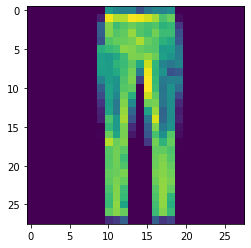

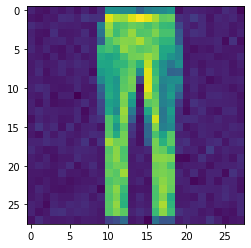

In [285]:
plt.imshow(xx[i].reshape(28,28))
plt.show()
plt.imshow(_xx_[i].reshape(28,28))
plt.show()
i+=1

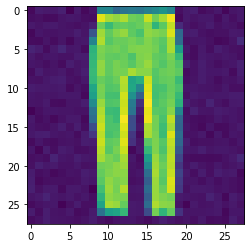

In [121]:
plt.imshow(_xx_[0].reshape(28,28))

In [122]:
diff = (dsts-yout)
torch.abs(diff).max()

tensor(0.0039, device='cuda:1', grad_fn=<MaxBackward1>)

(array([3.587e+03, 3.578e+03, 3.130e+03, 2.960e+03, 2.633e+03, 2.431e+03,
        2.101e+03, 1.949e+03, 1.691e+03, 1.503e+03, 1.338e+03, 1.208e+03,
        1.104e+03, 1.052e+03, 9.530e+02, 8.480e+02, 7.950e+02, 7.130e+02,
        6.210e+02, 5.930e+02, 4.770e+02, 4.670e+02, 3.780e+02, 3.500e+02,
        2.870e+02, 2.820e+02, 2.180e+02, 1.720e+02, 1.610e+02, 1.550e+02,
        1.210e+02, 1.150e+02, 1.120e+02, 8.700e+01, 7.200e+01, 7.200e+01,
        7.900e+01, 6.100e+01, 6.600e+01, 6.200e+01, 4.200e+01, 4.400e+01,
        5.000e+01, 3.100e+01, 4.000e+01, 2.700e+01, 3.300e+01, 3.400e+01,
        3.600e+01, 2.300e+01, 2.400e+01, 2.400e+01, 2.000e+01, 2.500e+01,
        1.800e+01, 2.300e+01, 1.900e+01, 8.000e+00, 1.400e+01, 1.000e+01,
        1.200e+01, 1.200e+01, 9.000e+00, 1.300e+01, 5.000e+00, 1.400e+01,
        4.000e+00, 6.000e+00, 4.000e+00, 7.000e+00, 1.000e+00, 4.000e+00,
        2.000e+00, 8.000e+00, 2.000e+00, 0.000e+00, 4.000e+00, 2.000e+00,
        2.000e+00, 3.000e+00, 3.000e+0

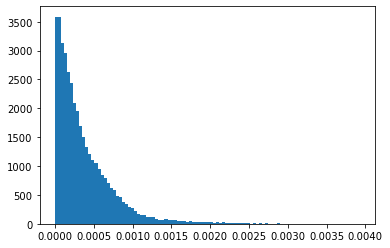

In [127]:
diffs = torch.abs(diff).data.cpu().numpy().reshape(-1)
plt.hist(diffs, bins=100)

tensor(2)

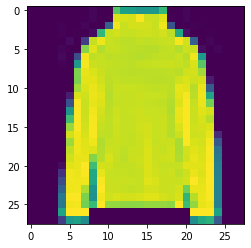

In [93]:
i = 8
plt.imshow(_xx[i].reshape(28,28))
_tt[i]

In [94]:
xx = _xx[i:i+1,:]
tt = _tt[i:i+1]

target_class = 0
advt = tt*0+target_class

In [95]:
model.eval()

X = torch.autograd.Variable(xx, requires_grad=True)
yy = model(X.to(device))

In [96]:
torch.argmax(yy.data.cpu(), dim=1), tt, advt

(tensor([4]), tensor([2]), tensor([0]))

In [97]:
loss = criterion(yy, advt.to(device))

xx_grad = torch.autograd.grad(outputs=loss, inputs=X,
#                             grad_outputs=torch.ones_like(self.Y),
                            only_inputs=True, retain_graph=True, create_graph=True)[0]

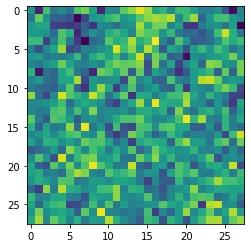

In [98]:
plt.imshow(xx_grad.data.cpu().reshape(28,28))

In [99]:
signed_grad = torch.sign(xx_grad.data.cpu())
# signed_grad = xx_grad.data.cpu()

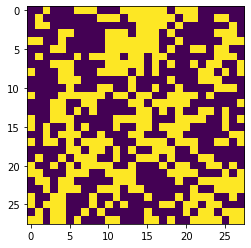

In [100]:
plt.imshow(signed_grad.reshape(28,28))

In [101]:
epsilon = 0.1
pertubation = xx - epsilon*signed_grad
xx_adv = pertubation
xx_adv = torch.clamp(pertubation, 0, 1)

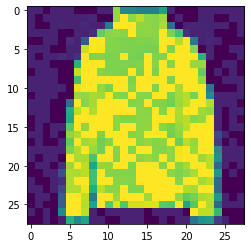

In [102]:
plt.imshow(xx_adv.reshape(28,28))

In [103]:
yy_adv = model(xx_adv.to(device))

In [104]:
yy_adv.argmax(dim=1)

tensor([8], device='cuda:1')

In [105]:
tt

tensor([2])